In [1]:
!pip install emojihunt --upgrade --q
print("Current project version:")
!pip freeze | grep emojihunt
from emojihunt import *
import json
import matplotlib.pyplot as plt
import cv2

from google.colab.patches import cv2_imshow
import numpy as np

Current project version:
emojihunt==1.1.1


# Template For EmojiHunt Project!

## EmojiHunt()
This is your emojihunt environment class you will use it for generating problem images, testing your configuration and getting your final scores on the trials.
### EmojiHunt.get_config()
This returns the dictionary of the configuration for the EmojiHunt. You can change the booleans in this dictionary to make the problem harder or easier.
### EmojiHunt.update_config(dict)
This writes the passed dictionary as the new configuration for the EmojiHunt. It should be formated as recived from .get_config(). 
### EmojiHunt.generate_image_and_points()
This returns 3 objects the target image, the example emoji and the ground truth real points. This function is avalible so you can test your method without needing to perform full official tests. The emoji image and the test target image are simple cv2 formated color images (BGR, numpy uint8). The ground truth points are a list of tuples of points [(x_0,y_0)..(x_n,y_n)]
### EmojiHunt.generate_image_and_points(ground_truth, predicted)
This function gives the score between two sets of emoji points, the ground truth given by .generate_image_and_points() and the prediction points. 
### EmojiHunt.offical_test(function, config)
For this function you explicitly give a callable object (either fucntion or class method) that takes in the positional arguments of image, sample_emoji. This function then runs multiple tests on this function and prints a report based on the config and the socres. Official tests are seeded so the test for each config is always the same. 
### Examples of the usage of all these methods are given below.


In [2]:
emoji_hunt_object = EmojiHunt() 
transforms = {
  "emoji_transforms": {
    "Add": False,
    "Multiply": False,
    "Cutout": False,
    "CoarseDropout": False,
    "CoarseSaltAndPepper": False,
    "JpegCompression": False,
    "BlendAlpha": False,
    "BlendAlphaRegularGrid": False,
    "GaussianBlur": True,
    "MotionBlur": False,
    "MultiplyHueAndSaturation": False,
    "Grayscale": False,
    "ChangeColorTemperature": False,
    "SigmoidContrast": False,
    "CLAHE": False,
    "Emboss": False,
    "DirectedEdgeDetect": False,
    "Fliplr": False,
    "PiecewiseAffine": False,
    "PerspectiveTransform": False,
    "WithPolarWarping": False,
    "Rot90": False,
    "ElasticTransformation": False,
    "Jigsaw": False
  }
}
emoji_hunt_object.update_config(transforms)

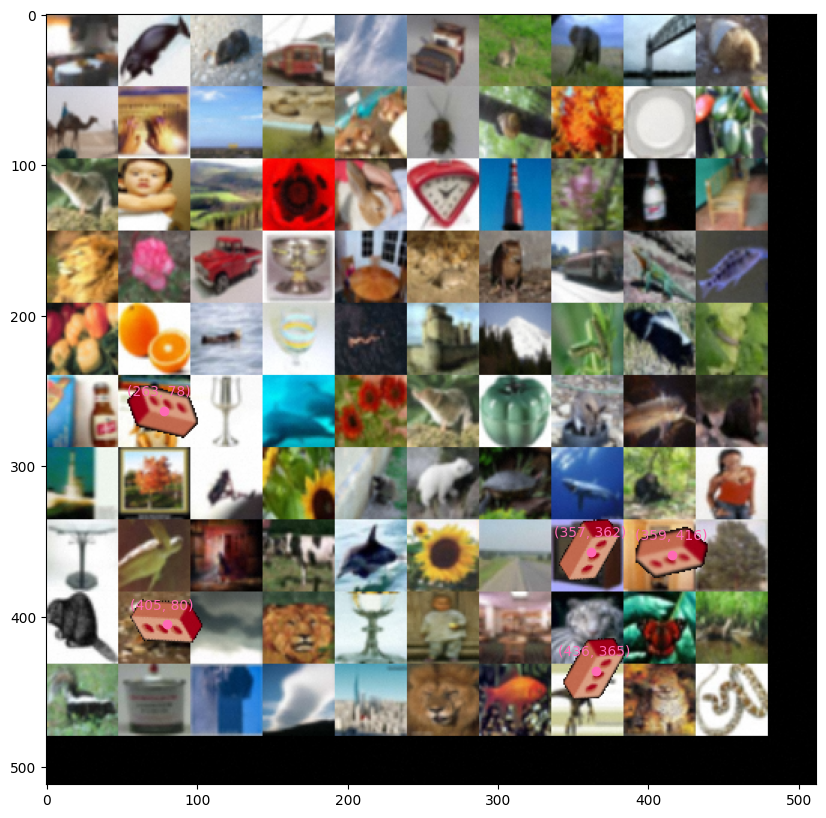

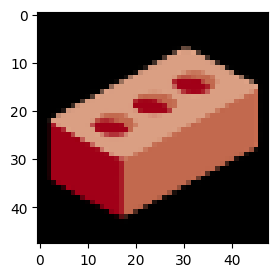

In [177]:
test_image, emoji_target, gt_points = emoji_hunt_object.generate_image_and_points()

plt.figure(figsize = (10,10))
imgplot = plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
x = [p[0] for p in gt_points]
y = [p[1] for p in gt_points]

plt.scatter(y, x, color="hotpink")
for p in gt_points:
    plt.annotate(f"{(p[0], p[1])}", (p[1] - 25, p[0] - 10), color="hotpink")

plt.show()
plt.figure(figsize = (3,3))
imgplot2 = plt.imshow(cv2.cvtColor(emoji_target, cv2.COLOR_BGR2RGB))
plt.show()

In [178]:
def segment_image(image):
  h, w = image.shape[:2]
  sub_h, sub_w = emoji_target.shape[:2]
  window = 12

  sub_images = []
  for y in range(0, h - sub_h, window):
    for x in range(0, w - sub_w, window):
      sub_image = image[y: y + sub_h, x: x + sub_w]
      centre_point = (int( y + (sub_h / 2)), int( x + (sub_w / 2)))
      sub_images.append((sub_image, centre_point))

  return sub_images

In [179]:
def non_max_suppression(keypoints, radius):
    non_duplicate = {}
    for item in keypoints:
      point = item[1]
      if point not in non_duplicate:
        non_duplicate[point] = item
        
    keypoints = np.array(list(non_duplicate.values()), dtype=object)
    selected_keypoints = []
    
    while len(keypoints) > 0:
      selected_keypoint = keypoints[0]
      selected_keypoints.append(selected_keypoint)

      distances = np.array([np.linalg.norm(np.array(keypoint[1]) - np.array(selected_keypoint[1])) for keypoint in keypoints])

      mask = distances < radius
      keypoints = [keypoints[i] for i in range(len(keypoints)) if not mask[i]]

    return selected_keypoints

In [180]:
def sift_filter(image, emoji):
  sift = cv2.SIFT_create()
  kp = []

  ref = cv2.cvtColor(emoji.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  kp_ref, desc_ref = sift.detectAndCompute(ref, None)

  filtered = segment_image(image)
  for img in filtered:
    colour_ROI, point = img[0], img[1]
    ROI = cv2.cvtColor(colour_ROI.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    try:
      kp_ROI, desc_ROI = sift.detectAndCompute(ROI, None)
      assert len(kp_ROI) > 0
    except AssertionError:
      continue

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc_ref, desc_ROI, k=2)

    good_matches = []

    max_length = max([match[0].distance for match in matches])
    min_length = min([match[0].distance for match in matches])
    factor = np.sqrt(min_length / (min_length + max_length))

    try:
      for m, n in matches:
        if m.distance < factor * n.distance:
          good_matches.append([m])
          kp.append((colour_ROI, point))

    except ValueError:
      pass

  suppressed = non_max_suppression(keypoints=kp, radius=48)

  return suppressed

In [181]:
def compute_histogram(image):
  gray = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
  hist_size = 256
  hist_range = (0, 256)
  hist = cv2.calcHist([gray], [0], None, [hist_size], hist_range, accumulate=False)

  # Remove contribution of pixels with intensity 0
  hist[0] = 0

  return hist 

def plot_histogram(histogram):
  plt.plot(histogram, color="hotpink")
  plt.show()

def histogram_similarity(histogram1, histogram2):
  hist1_norm = cv2.normalize(histogram1, histogram1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  hist2_norm = cv2.normalize(histogram2, histogram2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  bhattacharyya = cv2.compareHist(hist1_norm, hist2_norm, cv2.HISTCMP_BHATTACHARYYA)

  return bhattacharyya

In [183]:
def bhatt_filter(image, emoji):
  emoji_hist = compute_histogram(emoji)
  sub_images = sift_filter(image, emoji)

  bhatts = []
  for item in sub_images:
    sub_image = item[0]
    point = item[1]
    hist = compute_histogram(sub_image)
    score = histogram_similarity(emoji_hist, hist)
    bhatts.append((score, point))

  scores = [item[0] for item in bhatts]
  min_score, mean_score, std_score = np.amin(scores), np.mean(scores), np.std(scores)

  factor = 1.275
  coefficient_variation = std_score / mean_score
  ratio = coefficient_variation * factor
  
  filtered = []
  for i, item in enumerate(bhatts):
    score = item[0]
    point = item[1]
    if np.isclose(score, min_score, rtol=ratio):
      filtered.append(point)

  return filtered

In [184]:
def result_plot(image, emoji, selected_keypoints):
  x = [p[0] for p in selected_keypoints]
  y = [p[1] for p in selected_keypoints]

  plt.figure(figsize = (10,10))
  imgplot = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  plt.scatter(y, x, color="hotpink")
  for p in selected_keypoints:
    plt.annotate(f"{(p[0], p[1])}", (p[1] - 25, p[0] - 10), color="hotpink")

  plt.show()
  plt.figure(figsize = (3,3))
  imgplot2 = plt.imshow(cv2.cvtColor(emoji, cv2.COLOR_BGR2RGB))
  plt.show()

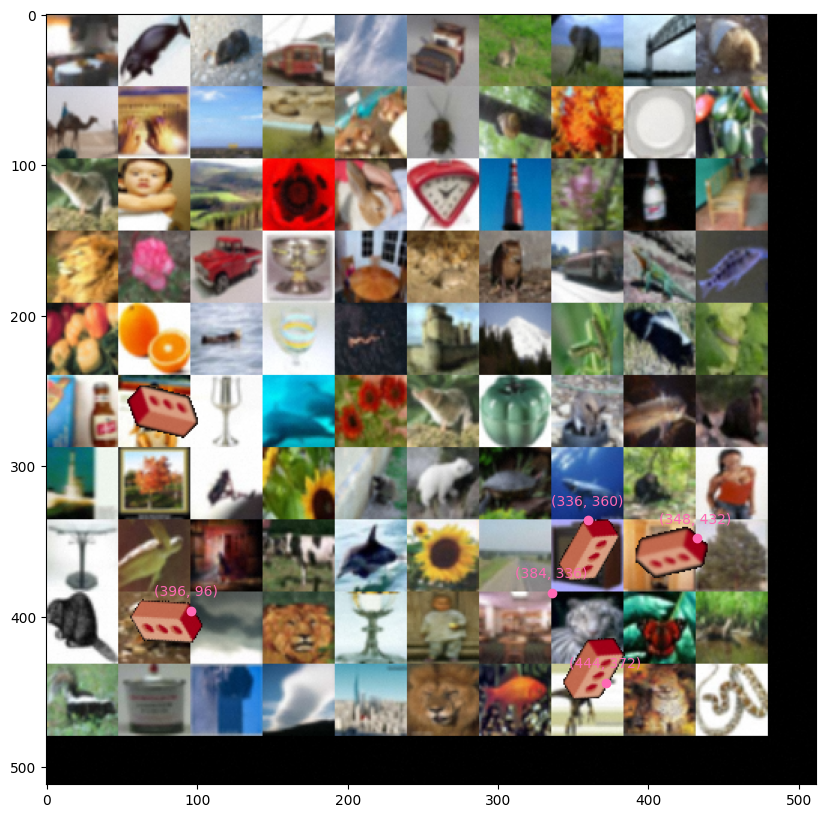

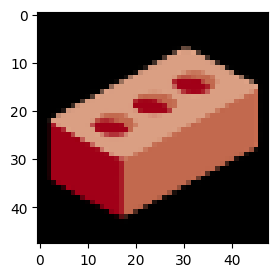

~~~~~STARTING TEST~~~~~~
Enabled Augmentations....
     GaussianBlur
Scores (lower is better)....
    Run 0 -> 348.26955068222827
    Run 1 -> 379.1545501890143
    Run 2 -> 83.3769070077316
    Run 3 -> 115.24638958923398
    Run 4 -> 210.41383084961126
    Run 5 -> 148.9881735294697
    Run 6 -> 236.69602647649964
    Run 7 -> 311.9366050751675
    Run 8 -> 158.39161871439467
    Run 9 -> 157.3096135606676
    Run 10 -> 267.4839452477979
    Run 11 -> 265.43073376569214
    Run 12 -> 345.35782197583063
    Run 13 -> 270.4428774066777
    Run 14 -> 427.41202265916655
    Run 15 -> 194.30058500634706
    Run 16 -> 6.6463415374286114
    Run 17 -> 68.3666804127648
    Run 18 -> 263.6157731058639
    Run 19 -> 27.567037625148235
    Run 20 -> 481.00535591346534
    Run 21 -> 128.1680505146441
    Run 22 -> 168.9337815036482
    Run 23 -> 220.38374394554404
    Run 24 -> 102.30923372934119
    Run 25 -> 234.18221558508145
    Run 26 -> 16.36665261549291
    Run 27 -> 132.30646242719968
  

In [185]:
# Our score
keypoints = bhatt_filter(test_image, emoji_target)
result_plot(test_image, emoji_target, keypoints)

emoji_hunt_object.offical_test(bhatt_filter, emoji_hunt_object.get_config())